In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/Tamanna34/super-resolution.git

fatal: destination path 'super-resolution' already exists and is not an empty directory.


In [ ]:
!pip install -r /content/super-resolution/requirements.txt

In [ ]:
!unzip  /content/drive/MyDrive/training_dataset_2.zip


Archive:  /content/drive/MyDrive/training_dataset_2.zip
replace __MACOSX/._training_dataset_2? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!unzip /content/drive/MyDrive/test_dataset123.zip

Archive:  /content/drive/MyDrive/test_dataset123.zip
replace __MACOSX/._test_dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install fastcore -U

In [ ]:
import PIL
from PIL import Image
import os
import json
import random
import torch
import torchvision.transforms.functional as FT
import math
print(PIL.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Some constants
rgb_weights = torch.FloatTensor([65.481, 128.553, 24.966]).to(device)
imagenet_mean = torch.FloatTensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(2)
imagenet_std = torch.FloatTensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(2)
imagenet_mean_cuda = torch.FloatTensor([0.485, 0.456, 0.406]).to(device).unsqueeze(0).unsqueeze(2).unsqueeze(3)
imagenet_std_cuda = torch.FloatTensor([0.229, 0.224, 0.225]).to(device).unsqueeze(0).unsqueeze(2).unsqueeze(3)


def create_data_lists(train_folders, test_folders, min_size, output_folder):
    """
    Create lists for images in the training set and each of the test sets.

    :param train_folders: folders containing the training images; these will be merged
    :param test_folders: folders containing the test images; each test folder will form its own test set
    :param min_size: minimum width and height of images to be considered
    :param output_folder: save data lists here
    """
    print("\nCreating data lists... this may take some time.\n")
    train_images = list()
    for d in train_folders:
        # print(f'd={d}')

        # print('.DS_Store' in lista)
        for i in os.listdir(d):
            if i!='.DS_Store':
              print(f'i={i}')
              img_path = os.path.join(d, i)
              img = Image.open(img_path, mode='r')
              if img.width >= min_size and img.height >= min_size:
                  train_images.append(img_path)
        print(train_images[0:10])
    print("There are %d images in the training data.\n" % len(train_images))
    with open(os.path.join(output_folder, 'train_images.json'), 'w') as j:
        json.dump(train_images, j)

    for d in test_folders:
        test_images = list()
        test_name = d.split("/")[-1]
        for i in os.listdir(d):
            img_path = os.path.join(d, i)
            img = Image.open(img_path, mode='r')
            if img.width >= min_size and img.height >= min_size:
                test_images.append(img_path)
        print("There are %d images in the %s test data.\n" % (len(test_images), test_name))
        with open(os.path.join(output_folder, test_name + '_test_images.json'), 'w') as j:
            json.dump(test_images, j)

    print("JSONS containing lists of Train and Test images have been saved to %s\n" % output_folder)


def convert_image(img, source, target):
    """
    Convert an image from a source format to a target format.

    :param img: image
    :param source: source format, one of 'pil' (PIL image), '[0, 1]' or '[-1, 1]' (pixel value ranges)
    :param target: target format, one of 'pil' (PIL image), '[0, 255]', '[0, 1]', '[-1, 1]' (pixel value ranges),
                   'imagenet-norm' (pixel values standardized by imagenet mean and std.),
                   'y-channel' (luminance channel Y in the YCbCr color format, used to calculate PSNR and SSIM)
    :return: converted image
    """
    assert source in {'pil', '[0, 1]', '[-1, 1]'}, "Cannot convert from source format %s!" % source
    assert target in {'pil', '[0, 255]', '[0, 1]', '[-1, 1]', 'imagenet-norm',
                      'y-channel'}, "Cannot convert to target format %s!" % target

    # Convert from source to [0, 1]
    if source == 'pil':
        img = FT.to_tensor(img)

    elif source == '[0, 1]':
        pass  # already in [0, 1]

    elif source == '[-1, 1]':
        img = (img + 1.) / 2.

    # Convert from [0, 1] to target
    if target == 'pil':
        img = FT.to_pil_image(img)

    elif target == '[0, 255]':
        img = 255. * img

    elif target == '[0, 1]':
        pass  # already in [0, 1]

    elif target == '[-1, 1]':
        img = 2. * img - 1.

    elif target == 'imagenet-norm':
        if img.ndimension() == 3:
            img = (img - imagenet_mean) / imagenet_std
        elif img.ndimension() == 4:
            img = (img - imagenet_mean_cuda) / imagenet_std_cuda

    elif target == 'y-channel':
        # Based on definitions at https://github.com/xinntao/BasicSR/wiki/Color-conversion-in-SR
        # torch.dot() does not work the same way as numpy.dot()
        # So, use torch.matmul() to find the dot product between the last dimension of an 4-D tensor and a 1-D tensor
        img = torch.matmul(255. * img.permute(0, 2, 3, 1)[:, 4:-4, 4:-4, :], rgb_weights) / 255. + 16.

    return img


class ImageTransforms(object):
    """
    Image transformation pipeline.
    """

    def __init__(self, split, crop_size, scaling_factor, lr_img_type, hr_img_type):
        """
        :param split: one of 'train' or 'test'
        :param crop_size: crop size of HR images
        :param scaling_factor: LR images will be downsampled from the HR images by this factor
        :param lr_img_type: the target format for the LR image; see convert_image() above for available formats
        :param hr_img_type: the target format for the HR image; see convert_image() above for available formats
        """
        self.split = split.lower()
        self.crop_size = crop_size
        self.scaling_factor = scaling_factor
        self.lr_img_type = lr_img_type
        self.hr_img_type = hr_img_type

        assert self.split in {'train', 'test'}

    def __call__(self, img):
        """
        :param img: a PIL source image from which the HR image will be cropped, and then downsampled to create the LR image
        :return: LR and HR images in the specified format
        """

        # Crop
        if self.split == 'train':
            # Take a random fixed-size crop of the image, which will serve as the high-resolution (HR) image
            left = random.randint(1, img.width - self.crop_size)
            top = random.randint(1, img.height - self.crop_size)
            right = left + self.crop_size
            bottom = top + self.crop_size
            hr_img = img.crop((left, top, right, bottom))
        else:
            # Take the largest possible center-crop of it such that its dimensions are perfectly divisible by the scaling factor
            x_remainder = img.width % self.scaling_factor
            y_remainder = img.height % self.scaling_factor
            left = x_remainder // 2
            top = y_remainder // 2
            right = left + (img.width - x_remainder)
            bottom = top + (img.height - y_remainder)
            hr_img = img.crop((left, top, right, bottom))

        # Downsize this crop to obtain a low-resolution version of it
        lr_img = hr_img.resize((int(hr_img.width / self.scaling_factor), int(hr_img.height / self.scaling_factor)),
                               Image.BICUBIC)

        # Sanity check
        assert hr_img.width == lr_img.width * self.scaling_factor and hr_img.height == lr_img.height * self.scaling_factor

        # Convert the LR and HR image to the required type
        lr_img = convert_image(lr_img, source='pil', target=self.lr_img_type)
        hr_img = convert_image(hr_img, source='pil', target=self.hr_img_type)

        return lr_img, hr_img


class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.

    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)


def save_checkpoint(state, filename):
    """
    Save model checkpoint.

    :param state: checkpoint contents
    """

    torch.save(state, filename)


def adjust_learning_rate(optimizer, shrink_factor):
    """
    Shrinks learning rate by a specified factor.

    :param optimizer: optimizer whose learning rate must be shrunk.
    :param shrink_factor: factor in interval (0, 1) to multiply learning rate with.
    """

    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))


9.3.0


In [ ]:
!pip install Pillow==9.3.0

In [ ]:
import torch
from torch.utils.data import Dataset
import json
import os
from PIL import Image
# from utils import ImageTransforms


class SRDataset(Dataset):
    """
    A PyTorch Dataset to be used by a PyTorch DataLoader.
    """

    def __init__(self, data_folder, split, crop_size, scaling_factor, lr_img_type, hr_img_type, test_data_name=None):
        """
        :param data_folder: # folder with JSON data files
        :param split: one of 'train' or 'test'
        :param crop_size: crop size of target HR images
        :param scaling_factor: the input LR images will be downsampled from the target HR images by this factor; the scaling done in the super-resolution
        :param lr_img_type: the format for the LR image supplied to the model; see convert_image() in utils.py for available formats
        :param hr_img_type: the format for the HR image supplied to the model; see convert_image() in utils.py for available formats
        :param test_data_name: if this is the 'test' split, which test dataset? (for example, "Set14")
        """

        self.data_folder = data_folder
        self.split = split.lower()
        self.crop_size = int(crop_size)
        self.scaling_factor = int(scaling_factor)
        self.lr_img_type = lr_img_type
        self.hr_img_type = hr_img_type
        self.test_data_name = test_data_name

        assert self.split in {'train', 'test'}
        if self.split == 'test' and self.test_data_name is None:
            raise ValueError("Please provide the name of the test dataset!")
        assert lr_img_type in {'[0, 255]', '[0, 1]', '[-1, 1]', 'imagenet-norm'}
        assert hr_img_type in {'[0, 255]', '[0, 1]', '[-1, 1]', 'imagenet-norm'}

        # If this is a training dataset, then crop dimensions must be perfectly divisible by the scaling factor
        # (If this is a test dataset, images are not cropped to a fixed size, so this variable isn't used)
        if self.split == 'train':
            assert self.crop_size % self.scaling_factor == 0, "Crop dimensions are not perfectly divisible by scaling factor! This will lead to a mismatch in the dimensions of the original HR patches and their super-resolved (SR) versions!"

        # Read list of image-paths
        if self.split == 'train':
            with open(os.path.join(data_folder, 'train_images.json'), 'r') as j:
                self.images = json.load(j)
        else:
            with open(os.path.join(data_folder, self.test_data_name + '_test_images.json'), 'r') as j:
                self.images = json.load(j)

        # Select the correct set of transforms
        self.transform = ImageTransforms(split=self.split,
                                         crop_size=self.crop_size,
                                         scaling_factor=self.scaling_factor,
                                         lr_img_type=self.lr_img_type,
                                         hr_img_type=self.hr_img_type)

    def __getitem__(self, i):
        """
        This method is required to be defined for use in the PyTorch DataLoader.

        :param i: index to retrieve
        :return: the 'i'th pair LR and HR images to be fed into the model
        """
        # Read image
        img = Image.open(self.images[i], mode='r')
        img = img.convert('RGB')
        if img.width <= 96 or img.height <= 96:
            print(self.images[i], img.width, img.height)
        lr_img, hr_img = self.transform(img)

        return lr_img, hr_img

    def __len__(self):
        """
        This method is required to be defined for use in the PyTorch DataLoader.

        :return: size of this data (in number of images)
        """
        return len(self.images)


In [ ]:
# from utils import create_data_lists

if __name__ == '__main__':
    create_data_lists(train_folders=["/content/training_dataset_2"],
                      test_folders=["/content/test_dataset/test__dataset"],
                      min_size=100,
                      output_folder='./')



Creating data lists... this may take some time.

i=im1227.jpg
i=im58.jpg
i=im1724.jpg
i=im1428.jpg
i=im233.jpg
i=im1562.jpg
i=im749.jpg
i=im597.jpg
i=im1053.jpg
i=im346.jpg
i=im592.jpg
i=im1401.jpg
i=im1804.jpg
i=im423.jpg
i=im696.jpg
i=im902.jpg
i=im1161.jpg
i=im541.jpg
i=im1970.jpg
i=im478.jpg
i=im661.jpg
i=im305.jpg
i=im399.jpg
i=im958.jpg
i=im1482.jpg
i=im1917.jpg
i=im349.jpg
i=im1668.jpg
i=im1675.jpg
i=im1719.jpg
i=im1258.jpg
i=im1375.jpg
i=im400.jpg
i=im988.jpg
i=im507.jpg
i=im748.jpg
i=im1629.jpg
i=im1313.jpg
i=im657.jpg
i=im1371.jpg
i=im228.jpg
i=im290.jpg
i=im950.jpg
i=im1146.jpg
i=im777.jpg
i=im1835.jpg
i=im1189.jpg
i=im415.jpg
i=im1259.jpg
i=im1954.jpg
i=im125.jpg
i=im1116.jpg
i=im728.jpg
i=im309.jpg
i=im414.jpg
i=im1739.jpg
i=im1709.jpg
i=im1015.jpg
i=im384.jpg
i=im328.jpg
i=im446.jpg
i=im1948.jpg
i=im776.jpg
i=im877.jpg
i=im1746.jpg
i=im94.jpg
i=im1603.jpg
i=im292.jpg
i=im1839.jpg
i=im994.jpg
i=im78.jpg
i=im429.jpg
i=im539.jpg
i=im107.jpg
i=im81.jpg
i=im1280.jpg
i=im857.j

In [ ]:
import torch
from torch import nn
import torchvision
import math


class ConvolutionalBlock(nn.Module):
    """
    A convolutional block, comprising convolutional, BN, activation layers.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, batch_norm=False, activation=None):
        """
        :param in_channels: number of input channels
        :param out_channels: number of output channe;s
        :param kernel_size: kernel size
        :param stride: stride
        :param batch_norm: include a BN layer?
        :param activation: Type of activation; None if none
        """
        super(ConvolutionalBlock, self).__init__()

        if activation is not None:
            activation = activation.lower()
            assert activation in {'prelu', 'leakyrelu', 'tanh'}

        # A container that will hold the layers in this convolutional block
        layers = list()

        # A convolutional layer
        layers.append(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                      padding=kernel_size // 2))

        # A batch normalization (BN) layer, if wanted
        if batch_norm is True:
            layers.append(nn.BatchNorm2d(num_features=out_channels))

        # An activation layer, if wanted
        if activation == 'prelu':
            layers.append(nn.PReLU())
        elif activation == 'leakyrelu':
            layers.append(nn.LeakyReLU(0.2))
        elif activation == 'tanh':
            layers.append(nn.Tanh())

        # Put together the convolutional block as a sequence of the layers in this container
        self.conv_block = nn.Sequential(*layers)

    def forward(self, input):
        """
        Forward propagation.

        :param input: input images, a tensor of size (N, in_channels, w, h)
        :return: output images, a tensor of size (N, out_channels, w, h)
        """
        output = self.conv_block(input)  # (N, out_channels, w, h)

        return output


class SubPixelConvolutionalBlock(nn.Module):
    """
    A subpixel convolutional block, comprising convolutional, pixel-shuffle, and PReLU activation layers.
    """

    def __init__(self, kernel_size=3, n_channels=64, scaling_factor=2):
        """
        :param kernel_size: kernel size of the convolution
        :param n_channels: number of input and output channels
        :param scaling_factor: factor to scale input images by (along both dimensions)
        """
        super(SubPixelConvolutionalBlock, self).__init__()

        # A convolutional layer that increases the number of channels by scaling factor^2, followed by pixel shuffle and PReLU
        self.conv = nn.Conv2d(in_channels=n_channels, out_channels=n_channels * (scaling_factor ** 2),
                              kernel_size=kernel_size, padding=kernel_size // 2)
        # These additional channels are shuffled to form additional pixels, upscaling each dimension by the scaling factor
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=scaling_factor)
        self.prelu = nn.PReLU()

    def forward(self, input):
        """
        Forward propagation.

        :param input: input images, a tensor of size (N, n_channels, w, h)
        :return: scaled output images, a tensor of size (N, n_channels, w * scaling factor, h * scaling factor)
        """
        output = self.conv(input)  # (N, n_channels * scaling factor^2, w, h)
        output = self.pixel_shuffle(output)  # (N, n_channels, w * scaling factor, h * scaling factor)
        output = self.prelu(output)  # (N, n_channels, w * scaling factor, h * scaling factor)

        return output


class ResidualBlock(nn.Module):
    """
    A residual block, comprising two convolutional blocks with a residual connection across them.
    """

    def __init__(self, kernel_size=3, n_channels=64):
        """
        :param kernel_size: kernel size
        :param n_channels: number of input and output channels (same because the input must be added to the output)
        """
        super(ResidualBlock, self).__init__()

        # The first convolutional block
        self.conv_block1 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                                              batch_norm=True, activation='PReLu')

        # The second convolutional block
        self.conv_block2 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                                              batch_norm=True, activation=None)

    def forward(self, input):
        """
        Forward propagation.

        :param input: input images, a tensor of size (N, n_channels, w, h)
        :return: output images, a tensor of size (N, n_channels, w, h)
        """
        residual = input  # (N, n_channels, w, h)
        output = self.conv_block1(input)  # (N, n_channels, w, h)
        output = self.conv_block2(output)  # (N, n_channels, w, h)
        output = output + residual  # (N, n_channels, w, h)

        return output


class SRResNet(nn.Module):
    """
    The SRResNet, as defined in the paper.
    """

    def __init__(self, large_kernel_size=9, small_kernel_size=3, n_channels=64, n_blocks=16, scaling_factor=4):
        """
        :param large_kernel_size: kernel size of the first and last convolutions which transform the inputs and outputs
        :param small_kernel_size: kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
        :param n_channels: number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
        :param n_blocks: number of residual blocks
        :param scaling_factor: factor to scale input images by (along both dimensions) in the subpixel convolutional block
        """
        super(SRResNet, self).__init__()

        # Scaling factor must be 2, 4, or 8
        scaling_factor = int(scaling_factor)
        assert scaling_factor in {2, 4, 8}, "The scaling factor must be 2, 4, or 8!"

        # The first convolutional block
        self.conv_block1 = ConvolutionalBlock(in_channels=3, out_channels=n_channels, kernel_size=large_kernel_size,
                                              batch_norm=False, activation='PReLu')

        # A sequence of n_blocks residual blocks, each containing a skip-connection across the block
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(kernel_size=small_kernel_size, n_channels=n_channels) for i in range(n_blocks)])

        # Another convolutional block
        self.conv_block2 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels,
                                              kernel_size=small_kernel_size,
                                              batch_norm=True, activation=None)

        # Upscaling is done by sub-pixel convolution, with each such block upscaling by a factor of 2
        n_subpixel_convolution_blocks = int(math.log2(scaling_factor))
        self.subpixel_convolutional_blocks = nn.Sequential(
            *[SubPixelConvolutionalBlock(kernel_size=small_kernel_size, n_channels=n_channels, scaling_factor=2) for i
              in range(n_subpixel_convolution_blocks)])

        # The last convolutional block
        self.conv_block3 = ConvolutionalBlock(in_channels=n_channels, out_channels=3, kernel_size=large_kernel_size,
                                              batch_norm=False, activation='Tanh')

    def forward(self, lr_imgs):
        """
        Forward prop.

        :param lr_imgs: low-resolution input images, a tensor of size (N, 3, w, h)
        :return: super-resolution output images, a tensor of size (N, 3, w * scaling factor, h * scaling factor)
        """
        output = self.conv_block1(lr_imgs)  # (N, 3, w, h)
        residual = output  # (N, n_channels, w, h)
        output = self.residual_blocks(output)  # (N, n_channels, w, h)
        output = self.conv_block2(output)  # (N, n_channels, w, h)
        output = output + residual  # (N, n_channels, w, h)
        output = self.subpixel_convolutional_blocks(output)  # (N, n_channels, w * scaling factor, h * scaling factor)
        sr_imgs = self.conv_block3(output)  # (N, 3, w * scaling factor, h * scaling factor)

        return sr_imgs


class Generator(nn.Module):
    """
    The generator in the SRGAN, as defined in the paper. Architecture identical to the SRResNet.
    """

    def __init__(self, large_kernel_size=9, small_kernel_size=3, n_channels=64, n_blocks=16, scaling_factor=4):
        """
        :param large_kernel_size: kernel size of the first and last convolutions which transform the inputs and outputs
        :param small_kernel_size: kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
        :param n_channels: number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
        :param n_blocks: number of residual blocks
        :param scaling_factor: factor to scale input images by (along both dimensions) in the subpixel convolutional block
        """
        super(Generator, self).__init__()

        # The generator is simply an SRResNet, as above
        self.net = SRResNet(large_kernel_size=large_kernel_size, small_kernel_size=small_kernel_size,
                            n_channels=n_channels, n_blocks=n_blocks, scaling_factor=scaling_factor)

    def initialize_with_srresnet(self, srresnet_checkpoint):
        """
        Initialize with weights from a trained SRResNet.

        :param srresnet_checkpoint: checkpoint filepath
        """
        srresnet = torch.load(srresnet_checkpoint,map_location=torch.device('cpu'))['model']
        self.net.load_state_dict(srresnet.state_dict())

        print("\nLoaded weights from pre-trained SRResNet.\n")

    def forward(self, lr_imgs):
        """
        Forward prop.

        :param lr_imgs: low-resolution input images, a tensor of size (N, 3, w, h)
        :return: super-resolution output images, a tensor of size (N, 3, w * scaling factor, h * scaling factor)
        """
        sr_imgs = self.net(lr_imgs)  # (N, n_channels, w * scaling factor, h * scaling factor)

        return sr_imgs


class Discriminator(nn.Module):
    """
    The discriminator in the SRGAN, as defined in the paper.
    """

    def __init__(self, kernel_size=3, n_channels=64, n_blocks=8, fc_size=1024):
        """
        :param kernel_size: kernel size in all convolutional blocks
        :param n_channels: number of output channels in the first convolutional block, after which it is doubled in every 2nd block thereafter
        :param n_blocks: number of convolutional blocks
        :param fc_size: size of the first fully connected layer
        """
        super(Discriminator, self).__init__()

        in_channels = 3

        # A series of convolutional blocks
        # The first, third, fifth (and so on) convolutional blocks increase the number of channels but retain image size
        # The second, fourth, sixth (and so on) convolutional blocks retain the same number of channels but halve image size
        # The first convolutional block is unique because it does not employ batch normalization
        conv_blocks = list()
        for i in range(n_blocks):
            out_channels = (n_channels if i is 0 else in_channels * 2) if i % 2 is 0 else in_channels
            conv_blocks.append(
                ConvolutionalBlock(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                   stride=1 if i % 2 is 0 else 2, batch_norm=i is not 0, activation='LeakyReLu'))
            in_channels = out_channels
        self.conv_blocks = nn.Sequential(*conv_blocks)

        # An adaptive pool layer that resizes it to a standard size
        # For the default input size of 96 and 8 convolutional blocks, this will have no effect
        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 6))

        self.fc1 = nn.Linear(out_channels * 6 * 6, fc_size)

        self.leaky_relu = nn.LeakyReLU(0.2)

        self.fc2 = nn.Linear(1024, 1)

        # Don't need a sigmoid layer because the sigmoid operation is performed by PyTorch's nn.BCEWithLogitsLoss()

    def forward(self, imgs):
        """
        Forward propagation.

        :param imgs: high-resolution or super-resolution images which must be classified as such, a tensor of size (N, 3, w * scaling factor, h * scaling factor)
        :return: a score (logit) for whether it is a high-resolution image, a tensor of size (N)
        """
        batch_size = imgs.size(0)
        output = self.conv_blocks(imgs)
        output = self.adaptive_pool(output)
        output = self.fc1(output.view(batch_size, -1))
        output = self.leaky_relu(output)
        logit = self.fc2(output)

        return logit


class TruncatedVGG19(nn.Module):
    """
    A truncated VGG19 network, such that its output is the 'feature map obtained by the j-th convolution (after activation)
    before the i-th maxpooling layer within the VGG19 network', as defined in the paper.

    Used to calculate the MSE loss in this VGG feature-space, i.e. the VGG loss.
    """

    def __init__(self, i, j):
        """
        :param i: the index i in the definition above
        :param j: the index j in the definition above
        """
        super(TruncatedVGG19, self).__init__()

        # Load the pre-trained VGG19 available in torchvision
        vgg19 = torchvision.models.vgg19(pretrained=True)

        maxpool_counter = 0
        conv_counter = 0
        truncate_at = 0
        # Iterate through the convolutional section ("features") of the VGG19
        for layer in vgg19.features.children():
            truncate_at += 1

            # Count the number of maxpool layers and the convolutional layers after each maxpool
            if isinstance(layer, nn.Conv2d):
                conv_counter += 1
            if isinstance(layer, nn.MaxPool2d):
                maxpool_counter += 1
                conv_counter = 0

            # Break if we reach the jth convolution after the (i - 1)th maxpool
            if maxpool_counter == i - 1 and conv_counter == j:
                break

        # Check if conditions were satisfied
        assert maxpool_counter == i - 1 and conv_counter == j, "One or both of i=%d and j=%d are not valid choices for the VGG19!" % (
            i, j)

        # Truncate to the jth convolution (+ activation) before the ith maxpool layer
        self.truncated_vgg19 = nn.Sequential(*list(vgg19.features.children())[:truncate_at + 1])

    def forward(self, input):
        """
        Forward propagation
        :param input: high-resolution or super-resolution images, a tensor of size (N, 3, w * scaling factor, h * scaling factor)
        :return: the specified VGG19 feature map, a tensor of size (N, feature_map_channels, feature_map_w, feature_map_h)
        """
        output = self.truncated_vgg19(input)  # (N, feature_map_channels, feature_map_w, feature_map_h)

        return output


<>:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:258: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:258: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:258: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:258: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-10-431dc0d3fb8a>:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
  out_channels = (n_channels if i is 0 else in_channels * 2) if i % 2 is 0 else in_channels
<ipython-input-10-431dc0d3fb8a>:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
  out_channels = (n_channels if i is 0 else in_channels * 2) if i % 2 is 0 else in_channels
<ipython-input-10-431dc0d3fb8a>:258: SyntaxWarning: "is" with a literal. Did you mean "=="?
  stride=1 if i % 2 is 0 els

In [ ]:
import os
print(os.listdir())
import time
import torch.backends.cudnn as cudnn
import torch
from torch import nn


# Data parameters
data_folder = './'  # folder with JSON data files
crop_size = 96  # crop size of target HR images
scaling_factor = 4  # the scaling factor for the generator; the input LR images will be downsampled from the target HR images by this factor

# Model parameters
large_kernel_size = 9  # kernel size of the first and last convolutions which transform the inputs and outputs
small_kernel_size = 3  # kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
n_channels = 64  # number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
n_blocks = 16  # number of residual blocks

# Learning parameters
checkpoint = None  # path to model checkpoint, None if none
batch_size = 64 # batch size
start_epoch = 0  # start at this epoch
iterations = 78  # number of training iterations
workers = 4  # number of workers for loading data in the DataLoader
print_freq = 50 # print training status once every __ batches
lr = 1e-4  # learning rate
grad_clip = None  # clip if gradients are exploding

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cudnn.benchmark = True


def main():
    """
    Training.
    """
    global start_epoch, epoch, checkpoint

    # Initialize model or load checkpoint
    if checkpoint is None:
        model = SRResNet(large_kernel_size=large_kernel_size, small_kernel_size=small_kernel_size,
                         n_channels=n_channels, n_blocks=n_blocks, scaling_factor=scaling_factor)
        # Initialize the optimizer
        optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()),
                                     lr=lr)

    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        model = checkpoint['model']
        optimizer = checkpoint['optimizer']

    # Move to default device
    model = model.to(device)
    criterion = nn.MSELoss().to(device)

    # Custom dataloaders
    train_dataset = SRDataset(data_folder,
                              split='train',
                              crop_size=crop_size,
                              scaling_factor=scaling_factor,
                              lr_img_type='imagenet-norm',
                              hr_img_type='[-1, 1]')
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers,
                                               pin_memory=True)  # note that we're passing the collate function here

    print(f"length = {len(train_loader)}")

    # Total number of epochs to train for
    epochs = int(iterations // len(train_loader) + 1)

    # Epochs
    for epoch in range(start_epoch, epochs):
        # One epoch's training
        train(train_loader=train_loader,
              model=model,
              criterion=criterion,
              optimizer=optimizer,
              epoch=epoch)

        # Save checkpoint
        torch.save({'epoch': epoch,
                    'model': model,
                    'optimizer': optimizer},
                   'checkpoint_srresnet.pth.tar')


def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.

    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: content loss function (Mean Squared-Error loss)
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables batch normalization

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss

    start = time.time()

    # Batches
    for i, (lr_imgs, hr_imgs) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        lr_imgs = lr_imgs.to(device)  # (batch_size (N), 3, 24, 24), imagenet-normed
        hr_imgs = hr_imgs.to(device)  # (batch_size (N), 3, 96, 96), in [-1, 1]

        # Forward prop.
        sr_imgs = model(lr_imgs)  # (N, 3, 96, 96), in [-1, 1]

        # Loss
        loss = criterion(sr_imgs, hr_imgs)  # scalar

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update model
        optimizer.step()

        # Keep track of loss
        losses.update(loss.item(), lr_imgs.size(0))

        # Keep track of batch time
        batch_time.update(time.time() - start)

        # Reset start time
        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]----'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})----'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})----'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})'.format(epoch, i, len(train_loader),
                                                                    batch_time=batch_time,
                                                                    data_time=data_time, loss=losses))
    del lr_imgs, hr_imgs, sr_imgs  # free some memory since their histories may be stored


if __name__ == '__main__':
    main()


['.config', 'training_dataset_2', '__MACOSX', 'test__dataset_test_images.json', 'test_dataset', 'train_images.json', '.ipynb_checkpoints', 'drive', 'super-resolution', 'sample_data']
length = 32


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-5-b0a923b344c4>:163: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
<ipython-input-5-b0a923b344c4>:163: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
<ipython-input-5-b0a923b344c4>:163: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
<ip

Epoch: [0][0/32]----Batch Time 4.826 (4.826)----Data Time 0.875 (0.875)----Loss 0.4043 (0.4043)


<ipython-input-5-b0a923b344c4>:163: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
<ipython-input-5-b0a923b344c4>:163: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
<ipython-input-5-b0a923b344c4>:163: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
<ipython-input-5-b0a923b344c4>:163: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)


Epoch: [1][0/32]----Batch Time 1.698 (1.698)----Data Time 1.322 (1.322)----Loss 0.0600 (0.0600)


<ipython-input-5-b0a923b344c4>:163: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
<ipython-input-5-b0a923b344c4>:163: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
<ipython-input-5-b0a923b344c4>:163: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
<ipython-input-5-b0a923b344c4>:163: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)


Epoch: [2][0/32]----Batch Time 1.086 (1.086)----Data Time 0.816 (0.816)----Loss 0.0483 (0.0483)


In [ ]:
!pip install models

  Using cached models-0.9.3.tar.gz (16 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import time
import torch.backends.cudnn as cudnn
from torch import nn

# import models
# from datasets import SRDataset
# from utils import *

# Data parameters
data_folder = './'  # folder with JSON data files
crop_size = 96  # crop size of target HR images
scaling_factor = 4  # the scaling factor for the generator; the input LR images will be downsampled from the target HR images by this factor

# Generator parameters
large_kernel_size_g = 9  # kernel size of the first and last convolutions which transform the inputs and outputs
small_kernel_size_g = 3  # kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
n_channels_g = 64  # number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
n_blocks_g = 16  # number of residual blocks
srresnet_checkpoint = "./checkpoint_srresnet.pth.tar"  # filepath of the trained SRResNet checkpoint used for initialization

# Discriminator parameters
kernel_size_d = 3  # kernel size in all convolutional blocks
n_channels_d = 64  # number of output channels in the first convolutional block, after which it is doubled in every 2nd block thereafter
n_blocks_d = 8  # number of convolutional blocks
fc_size_d = 1024  # size of the first fully connected layer

# Learning parameters
checkpoint = None  # path to model (SRGAN) checkpoint, None if none
batch_size = 16  # batch size
start_epoch = 0  # start at this epoch
iterations = 2e5  # number of training iterations
workers = 2  # number of workers for loading data in the DataLoader
vgg19_i = 5  # the index i in the definition for VGG loss; see paper or models.py
vgg19_j = 4  # the index j in the definition for VGG loss; see paper or models.py
beta = 1e-3  # the coefficient to weight the adversarial loss in the perceptual loss
print_freq = 50  # print training status once every __ batches
lr = 1e-4  # learning rate
grad_clip = None  # clip if gradients are exploding

# Default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cudnn.benchmark = True


def main():
    """
    Training.
    """
    global start_epoch, epoch, checkpoint, srresnet_checkpoint

    # Initialize model or load checkpoint
    if checkpoint is None:
        # Generator
        generator = Generator(large_kernel_size=large_kernel_size_g,
                              small_kernel_size=small_kernel_size_g,
                              n_channels=n_channels_g,
                              n_blocks=n_blocks_g,
                              scaling_factor=scaling_factor)

        # Initialize generator network with pretrained SRResNet
        generator.initialize_with_srresnet(srresnet_checkpoint=srresnet_checkpoint)

        # Initialize generator's optimizer
        optimizer_g = torch.optim.Adam(params=filter(lambda p: p.requires_grad, generator.parameters()),
                                       lr=lr)

        # Discriminator
        discriminator = Discriminator(kernel_size=kernel_size_d,
                                      n_channels=n_channels_d,
                                      n_blocks=n_blocks_d,
                                      fc_size=fc_size_d)

        # Initialize discriminator's optimizer
        optimizer_d = torch.optim.Adam(params=filter(lambda p: p.requires_grad, discriminator.parameters()),
                                       lr=lr)

    else:
        checkpoint = torch.load(checkpoint,map_location=device)
        start_epoch = checkpoint['epoch'] + 1
        generator = checkpoint['generator']
        discriminator = checkpoint['discriminator']
        optimizer_g = checkpoint['optimizer_g']
        optimizer_d = checkpoint['optimizer_d']
        print("\nLoaded checkpoint from epoch %d.\n" % (checkpoint['epoch'] + 1))

    # Truncated VGG19 network to be used in the loss calculation
    truncated_vgg19 = TruncatedVGG19(i=vgg19_i, j=vgg19_j)
    truncated_vgg19.eval()

    # Loss functions
    content_loss_criterion = nn.MSELoss()
    adversarial_loss_criterion = nn.BCEWithLogitsLoss()

    # Move to default device
    generator = generator.to(device)
    discriminator = discriminator.to(device)
    truncated_vgg19 = truncated_vgg19.to(device)
    content_loss_criterion = content_loss_criterion.to(device)
    adversarial_loss_criterion = adversarial_loss_criterion.to(device)

    # Custom dataloaders
    train_dataset = SRDataset(data_folder,
                              split='train',
                              crop_size=crop_size,
                              scaling_factor=scaling_factor,
                              lr_img_type='imagenet-norm',
                              hr_img_type='imagenet-norm')
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers,
                                               pin_memory=True)
    print(len(train_loader))
    # Total number of epochs to train for
    epochs =4

    # Epochs
    for epoch in range(start_epoch, epochs):

        # At the halfway point, reduce learning rate to a tenth
        if epoch == int((iterations / 2) // len(train_loader) + 1):
            adjust_learning_rate(optimizer_g, 0.1)
            adjust_learning_rate(optimizer_d, 0.1)

        # One epoch's training
        train(train_loader=train_loader,
              generator=generator,
              discriminator=discriminator,
              truncated_vgg19=truncated_vgg19,
              content_loss_criterion=content_loss_criterion,
              adversarial_loss_criterion=adversarial_loss_criterion,
              optimizer_g=optimizer_g,
              optimizer_d=optimizer_d,
              epoch=epoch)

        # Save checkpoint
        torch.save({'epoch': epoch,
                    'generator': generator,
                    'discriminator': discriminator,
                    'optimizer_g': optimizer_g,
                    'optimizer_d': optimizer_d},
                   'checkpoint_srgan.pth.tar')


def train(train_loader, generator, discriminator, truncated_vgg19, content_loss_criterion, adversarial_loss_criterion,
          optimizer_g, optimizer_d, epoch):
    """
    One epoch's training.

    :param train_loader: train dataloader
    :param generator: generator
    :param discriminator: discriminator
    :param truncated_vgg19: truncated VGG19 network
    :param content_loss_criterion: content loss function (Mean Squared-Error loss)
    :param adversarial_loss_criterion: adversarial loss function (Binary Cross-Entropy loss)
    :param optimizer_g: optimizer for the generator
    :param optimizer_d: optimizer for the discriminator
    :param epoch: epoch number
    """
    # Set to train mode
    generator.train()
    discriminator.train()  # training mode enables batch normalization

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses_c = AverageMeter()  # content loss
    losses_a = AverageMeter()  # adversarial loss in the generator
    losses_d = AverageMeter()  # adversarial loss in the discriminator

    start = time.time()

    # Batches
    for i, (lr_imgs, hr_imgs) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        lr_imgs = lr_imgs.to(device)  # (batch_size (N), 3, 24, 24), imagenet-normed
        hr_imgs = hr_imgs.to(device)  # (batch_size (N), 3, 96, 96), imagenet-normed

        # GENERATOR UPDATE

        # Generate
        sr_imgs = generator(lr_imgs)  # (N, 3, 96, 96), in [-1, 1]
        sr_imgs = convert_image(sr_imgs, source='[-1, 1]', target='imagenet-norm')  # (N, 3, 96, 96), imagenet-normed

        # Calculate VGG feature maps for the super-resolved (SR) and high resolution (HR) images
        sr_imgs_in_vgg_space = truncated_vgg19(sr_imgs)
        hr_imgs_in_vgg_space = truncated_vgg19(hr_imgs).detach()  # detached because they're constant, targets

        # Discriminate super-resolved (SR) images
        sr_discriminated = discriminator(sr_imgs)  # (N)

        # Calculate the Perceptual loss
        content_loss = content_loss_criterion(sr_imgs_in_vgg_space, hr_imgs_in_vgg_space)
        adversarial_loss = adversarial_loss_criterion(sr_discriminated, torch.ones_like(sr_discriminated))
        perceptual_loss = content_loss + beta * adversarial_loss

        # Back-prop.
        optimizer_g.zero_grad()
        perceptual_loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer_g, grad_clip)

        # Update generator
        optimizer_g.step()

        # Keep track of loss
        losses_c.update(content_loss.item(), lr_imgs.size(0))
        losses_a.update(adversarial_loss.item(), lr_imgs.size(0))

        # DISCRIMINATOR UPDATE

        # Discriminate super-resolution (SR) and high-resolution (HR) images
        hr_discriminated = discriminator(hr_imgs)
        sr_discriminated = discriminator(sr_imgs.detach())
        # But didn't we already discriminate the SR images earlier, before updating the generator (G)? Why not just use that here?
        # Because, if we used that, we'd be back-propagating (finding gradients) over the G too when backward() is called
        # It's actually faster to detach the SR images from the G and forward-prop again, than to back-prop. over the G unnecessarily
        # See FAQ section in the tutorial

        # Binary Cross-Entropy loss
        adversarial_loss = adversarial_loss_criterion(sr_discriminated, torch.zeros_like(sr_discriminated)) + \
                           adversarial_loss_criterion(hr_discriminated, torch.ones_like(hr_discriminated))

        # Back-prop.
        optimizer_d.zero_grad()
        adversarial_loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer_d, grad_clip)

        # Update discriminator
        optimizer_d.step()

        # Keep track of loss
        losses_d.update(adversarial_loss.item(), hr_imgs.size(0))

        # Keep track of batch times
        batch_time.update(time.time() - start)

        # Reset start time
        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]----'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})----'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})----'
                  'Cont. Loss {loss_c.val:.4f} ({loss_c.avg:.4f})----'
                  'Adv. Loss {loss_a.val:.4f} ({loss_a.avg:.4f})----'
                  'Disc. Loss {loss_d.val:.4f} ({loss_d.avg:.4f})'.format(epoch,
                                                                          i,
                                                                          100,
                                                                          batch_time=batch_time,
                                                                          data_time=data_time,
                                                                          loss_c=losses_c,
                                                                          loss_a=losses_a,
                                                                          loss_d=losses_d))

    del lr_imgs, hr_imgs, sr_imgs, hr_imgs_in_vgg_space, sr_imgs_in_vgg_space, hr_discriminated, sr_discriminated  # free some memory since their histories may be stored


if __name__ == '__main__':
    main()


Loaded weights from pre-trained SRResNet.

125


<ipython-input-38-b0a923b344c4>:163: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
<ipython-input-38-b0a923b344c4>:163: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)


Epoch: [0][0/100]----Batch Time 0.882 (0.882)----Data Time 0.464 (0.464)----Cont. Loss 0.6304 (0.6304)----Adv. Loss 0.7126 (0.7126)----Disc. Loss 1.4011 (1.4011)
Epoch: [0][50/100]----Batch Time 0.395 (0.342)----Data Time 0.011 (0.014)----Cont. Loss 0.7170 (0.7628)----Adv. Loss 15.8251 (12.9408)----Disc. Loss 0.0388 (0.3084)
Epoch: [0][100/100]----Batch Time 0.231 (0.323)----Data Time 0.000 (0.009)----Cont. Loss 0.6381 (0.7318)----Adv. Loss 11.4139 (12.3820)----Disc. Loss 0.4048 (0.2846)


<ipython-input-38-b0a923b344c4>:163: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
<ipython-input-38-b0a923b344c4>:163: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)


Epoch: [1][0/100]----Batch Time 0.533 (0.533)----Data Time 0.228 (0.228)----Cont. Loss 0.9363 (0.9363)----Adv. Loss 6.6622 (6.6622)----Disc. Loss 0.0829 (0.0829)
Epoch: [1][50/100]----Batch Time 0.242 (0.240)----Data Time 0.000 (0.006)----Cont. Loss 0.6035 (0.6717)----Adv. Loss 14.9626 (10.9035)----Disc. Loss 0.0449 (0.1229)
Epoch: [1][100/100]----Batch Time 0.223 (0.236)----Data Time 0.000 (0.004)----Cont. Loss 0.8234 (0.6860)----Adv. Loss 11.3514 (11.5135)----Disc. Loss 0.3862 (0.1154)


<ipython-input-38-b0a923b344c4>:163: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
<ipython-input-38-b0a923b344c4>:163: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)


Epoch: [2][0/100]----Batch Time 0.726 (0.726)----Data Time 0.398 (0.398)----Cont. Loss 0.6256 (0.6256)----Adv. Loss 7.0698 (7.0698)----Disc. Loss 0.0352 (0.0352)
Epoch: [2][50/100]----Batch Time 0.224 (0.240)----Data Time 0.000 (0.010)----Cont. Loss 0.7331 (0.6470)----Adv. Loss 25.2640 (10.0816)----Disc. Loss 0.0828 (0.1818)
Epoch: [2][100/100]----Batch Time 0.227 (0.240)----Data Time 0.000 (0.006)----Cont. Loss 0.7091 (0.6666)----Adv. Loss 13.4549 (11.1212)----Disc. Loss 0.0005 (0.1227)


<ipython-input-38-b0a923b344c4>:163: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
<ipython-input-38-b0a923b344c4>:163: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)


Epoch: [3][0/100]----Batch Time 0.628 (0.628)----Data Time 0.312 (0.312)----Cont. Loss 0.7105 (0.7105)----Adv. Loss 11.3116 (11.3116)----Disc. Loss 0.0024 (0.0024)
Epoch: [3][50/100]----Batch Time 0.227 (0.259)----Data Time 0.000 (0.009)----Cont. Loss 1.0003 (0.6856)----Adv. Loss 10.6563 (13.7205)----Disc. Loss 0.0311 (0.0687)
Epoch: [3][100/100]----Batch Time 0.242 (0.256)----Data Time 0.000 (0.006)----Cont. Loss 0.5982 (0.7019)----Adv. Loss 9.9489 (11.5910)----Disc. Loss 0.0349 (0.0825)



For test__dataset:



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-5-b0a923b344c4>:163: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
<ipython-input-5-b0a923b344c4>:163: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
<ipython-input-5-b0a923b344c4>:163: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)


0
<class 'torch.Tensor'> torch.Size([3, 900, 900])


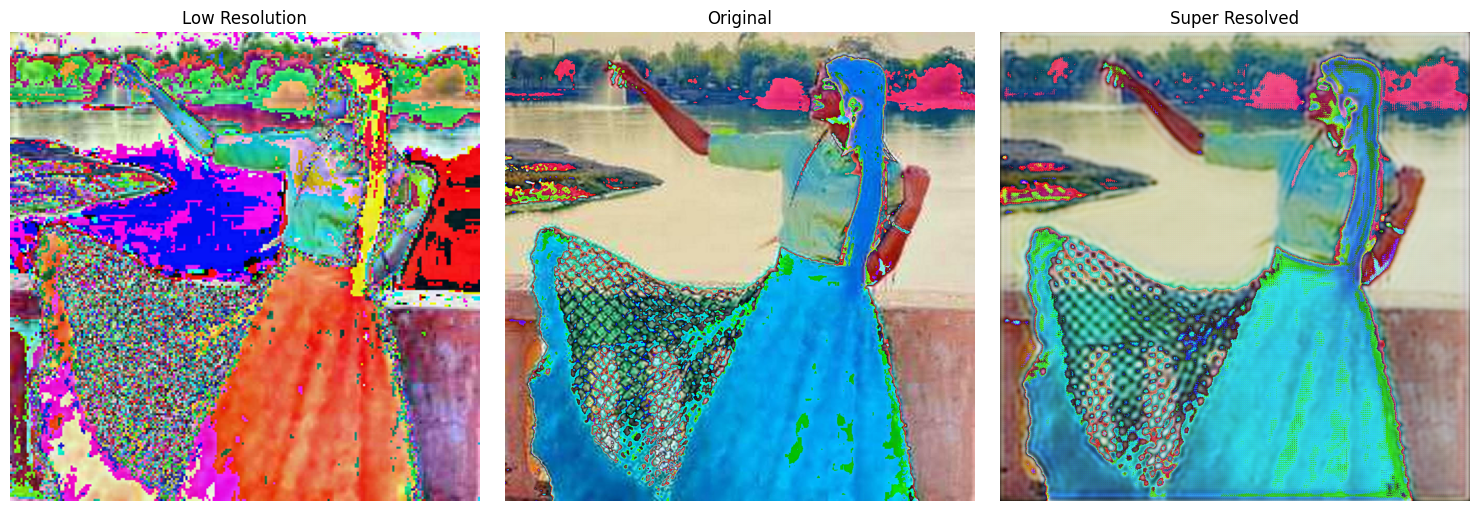

1
<class 'torch.Tensor'> torch.Size([3, 180, 320])


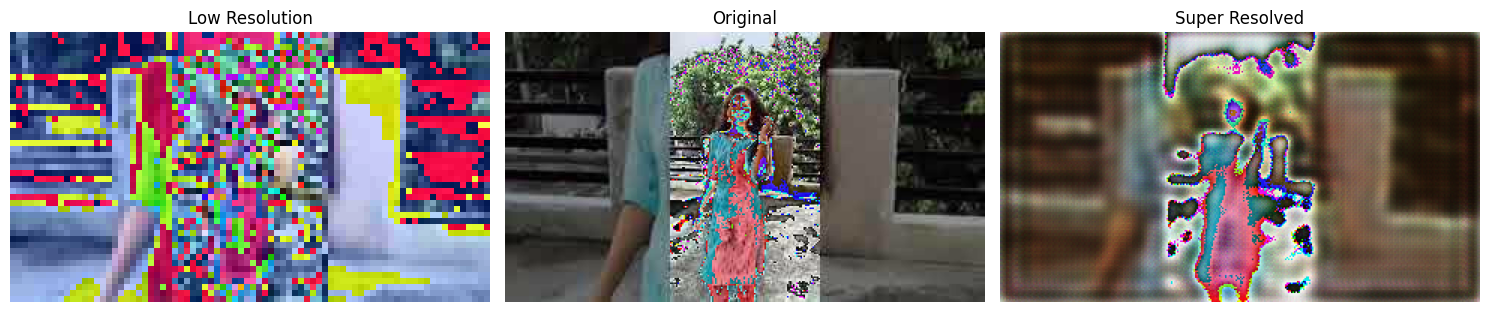

2
<class 'torch.Tensor'> torch.Size([3, 320, 320])


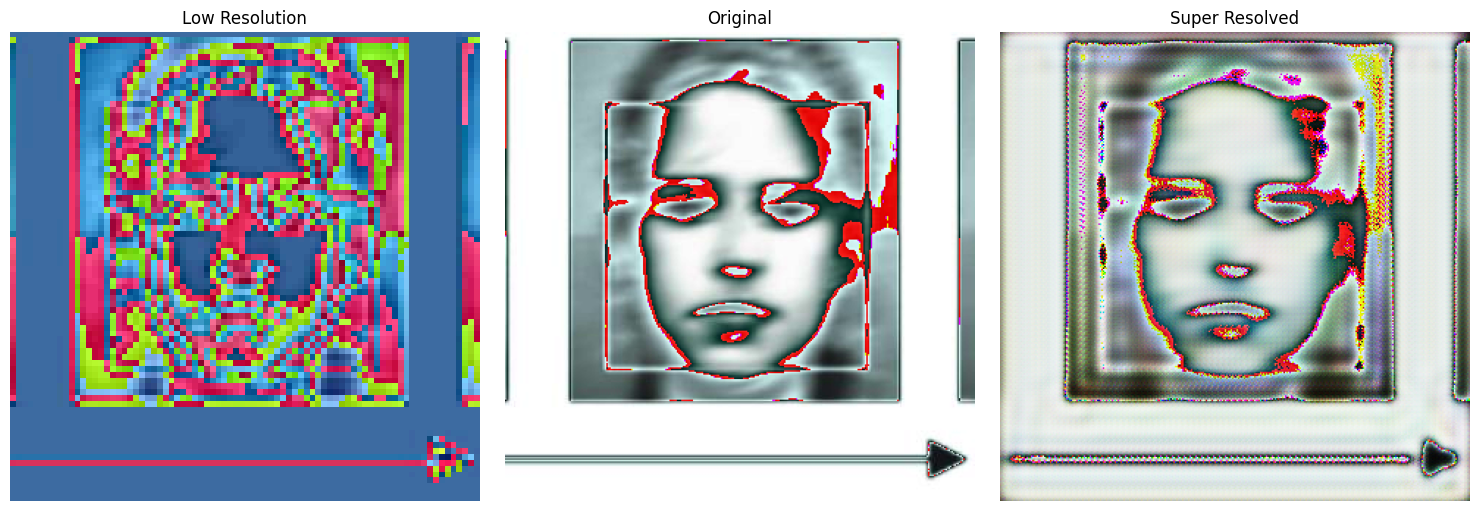

PSNR - 25.562
SSIM - 0.776




In [ ]:
# from utils import *
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from PIL import Image
# from datasets import SRDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.load with map_location=torch.device('cpu')

# Data
data_folder = "./"
test_data_names = ["test__dataset"]

# Model checkpoints
srgan_checkpoint = "./checkpoint_srgan.pth.tar"
srresnet_checkpoint = "./checkpoint_srresnet.pth.tar"

# Load model, either the SRResNet or the SRGAN
srresnet = torch.load(srresnet_checkpoint)['model'].to(device)
srresnet.eval()
model = srresnet
# srgan_generator = torch.load(srgan_checkpoint,map_location=torch.device('cpu'))['generator'].to(device)
# srgan_generator.eval()
# model = srgan_generator

# Evaluate
for test_data_name in test_data_names:
    print("\nFor %s:\n" % test_data_name)

    # Custom dataloader
    test_dataset = SRDataset(data_folder,
                             split='test',
                             crop_size=0,
                             scaling_factor=4,
                             lr_img_type='imagenet-norm',
                             hr_img_type='[-1, 1]',
                             test_data_name=test_data_name)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4,
                                              pin_memory=True)

    # Keep track of the PSNRs and the SSIMs across batches
    PSNRs = AverageMeter()
    SSIMs = AverageMeter()

    # Prohibit gradient computation explicitly because I had some problems with memory
    with torch.no_grad():
        # Batches
        for i, (lr_imgs, hr_imgs) in enumerate(test_loader):
            print(i)
            # Move to default device
            lr_imgs = lr_imgs.to(device)  # (batch_size (1), 3, w / 4, h / 4), imagenet-normed
            hr_imgs = hr_imgs.to(device)  # (batch_size (1), 3, w, h), in [-1, 1]

            # Forward prop.
            sr_imgs = model(lr_imgs)  # (1, 3, w, h), in [-1, 1]

            # Calculate PSNR and SSIM
            # sr_imgs_y = convert_image(sr_imgs, source='[-1, 1]', target='y-channel').squeeze(0)  # (w, h), in y-channel
            # hr_imgs_y = convert_image(hr_imgs, source='[-1, 1]', target='y-channel').squeeze(0)  # (w, h), in y-channel
            # sr_imgs = sr_imgs.view(sr_imgs.shape[1],sr_imgs.shape[2],sr_imgs.shape[3])
            # print(type(sr_imgs), sr_imgs.shape)
            # transform = T.ToPILImage()
            # img = transform(sr_imgs)
            # print(f'here is image {img}')
            # # img.show()
            # plt.imshow(img)
            # plt.axis('off')
            # plt.show()

            sr_imgs_y = convert_image(sr_imgs, source='[-1, 1]', target='y-channel').squeeze(0)  # (w, h), in y-channel
            hr_imgs_y = convert_image(hr_imgs, source='[-1, 1]', target='y-channel').squeeze(0)  # (w, h), in y-channel
            sr_imgs = sr_imgs.view(sr_imgs.shape[1], sr_imgs.shape[2], sr_imgs.shape[3])
            print(type(sr_imgs), sr_imgs.shape)
            transform = T.ToPILImage()
            sr_img_pil = transform(sr_imgs)
            hr_img_pil = transform(hr_imgs.squeeze(0))
            lr_img_pil = transform(lr_imgs.squeeze(0))

            # Create a figure with three subplots
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))

            # Plot the original low-resolution image
            axs[0].imshow(lr_img_pil)
            axs[0].axis('off')
            axs[0].set_title('Low Resolution')

            # Plot the original high-resolution image
            axs[1].imshow(hr_img_pil)
            axs[1].axis('off')
            axs[1].set_title('Original')

            # Plot the super-resolved image
            axs[2].imshow(sr_img_pil)
            axs[2].axis('off')
            axs[2].set_title('Super Resolved')

            lr_img_pil.save("low_resolution.jpg")
            hr_img_pil.save("high_resolution.jpg")
            sr_img_pil.save("super_resolved.jpg")

            # Adjust the layout and display the figure
            plt.tight_layout()
            plt.show()
            psnr = peak_signal_noise_ratio(hr_imgs_y.cpu().numpy(), sr_imgs_y.cpu().numpy(),
                                           data_range=255.)
            ssim = structural_similarity(hr_imgs_y.cpu().numpy(), sr_imgs_y.cpu().numpy(),
                                         data_range=255.)
            PSNRs.update(psnr, lr_imgs.size(0))
            SSIMs.update(ssim, lr_imgs.size(0))

    # Print average PSNR and SSIM
    print('PSNR - {psnrs.avg:.3f}'.format(psnrs=PSNRs))
    print('SSIM - {ssims.avg:.3f}'.format(ssims=SSIMs))

print("\n")


